In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, roc_auc_score

# "Adult" dataset.

The dataset contains information such as age, work class, education, marital status, occupation, relationship, race, sex, capital gain, capital loss, hours per week, and native country. It's a good dataset for practicing with logistic regression, decision trees, and other machine learning algorithms due to its mix of categorical and numerical data.

Used to predict whether an individual earns more than $50,000 per year based on various features.

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

data = pd.read_csv(url, names=column_names, header=None, na_values=" ?")
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Handling Nulls

In [4]:
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

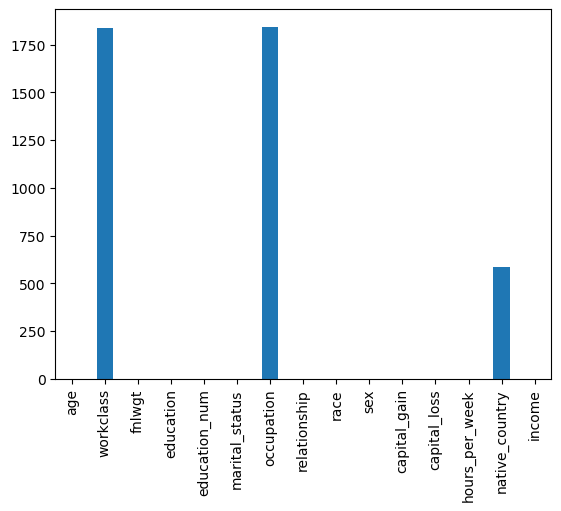

In [5]:
data.isna().sum().plot.bar()
plt.show()

In [6]:
imputer = SimpleImputer(strategy='most_frequent')
data['occupation'] = imputer.fit_transform(data[['occupation']])[:, 0]
data['workclass'] = imputer.fit_transform(data[['workclass']])[:, 0]
data['native_country'] = imputer.fit_transform(data[['native_country']])[:, 0]

# we could use KNNImputer for numerical variables

In [7]:
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

# Handling outliers

In [8]:
numerical_vars = data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Variables:", numerical_vars)

Numerical Variables: Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')


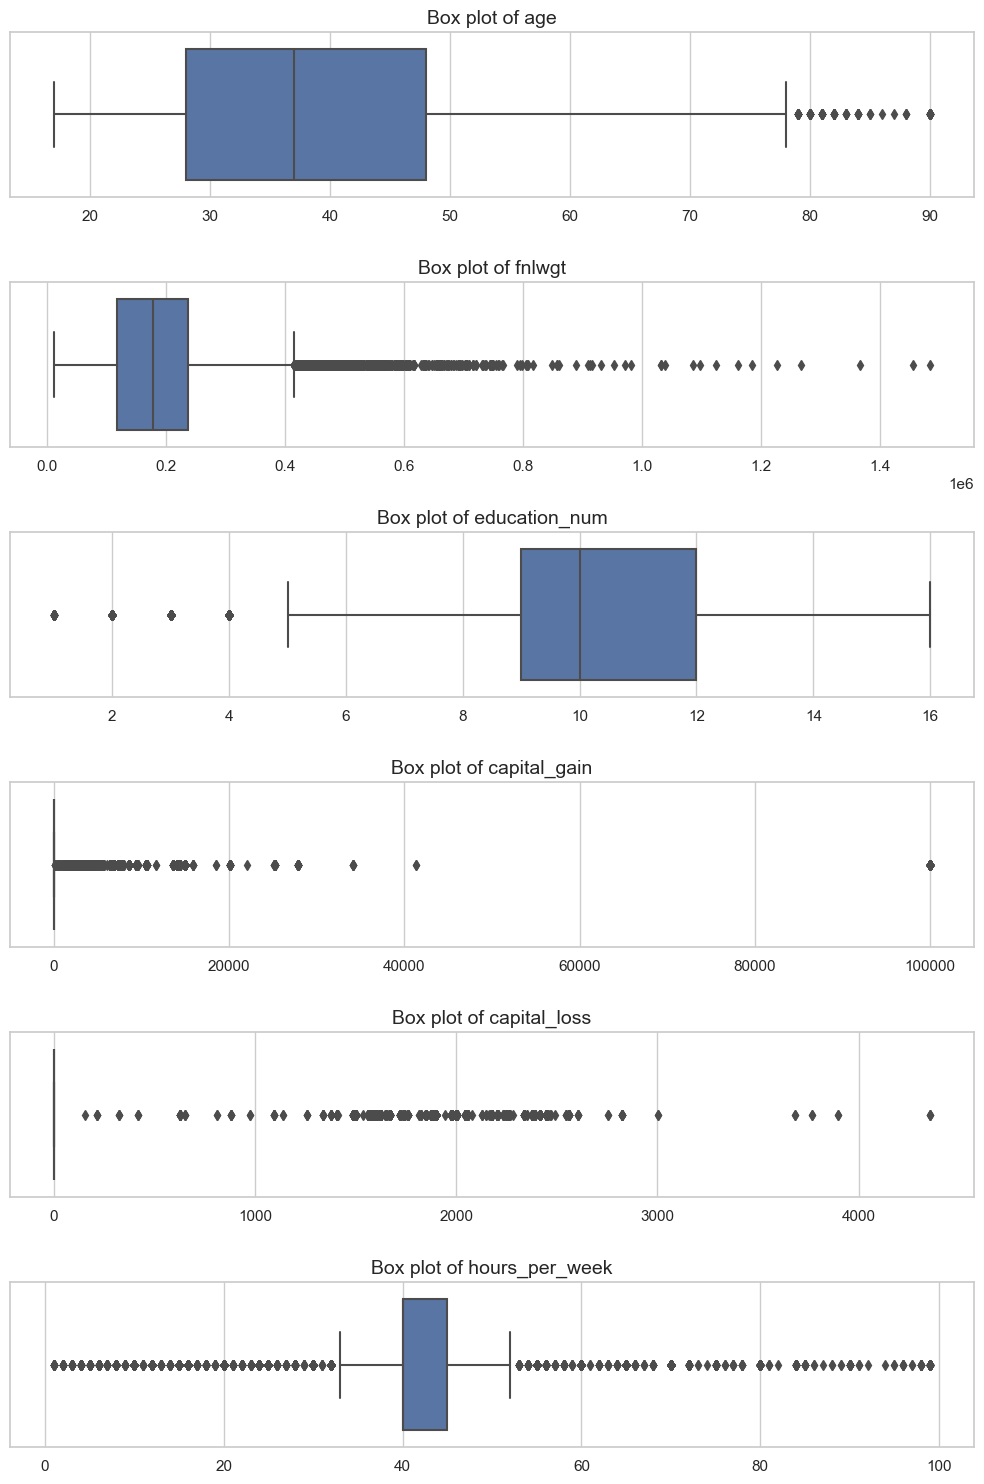

In [9]:
# Setting aesthetics for seaborn
sns.set(style="whitegrid")

# Creating a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(numerical_vars), ncols=1, figsize=(10, 15))

for i, var in enumerate(numerical_vars):
    sns.boxplot(x=data[var], ax=axes[i])
    axes[i].set_title(f'Box plot of {var}', fontsize=14)
    axes[i].set_xlabel('')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()


The `education_num` variable in the Adult dataset represents the number of years of education completed by an individual, often encoded as an ordinal variable. From the boxplot provided for `education_num`, it seems there are some data points that fall below the lower whisker, which could be considered outliers according to the IQR method.

However, in the case of a variable like `education_num`, which is ordinal and likely has a set range of acceptable values (e.g., 1 through 16, if it corresponds to the number of years of schooling from none to a doctorate degree), these "outliers" are likely not errors but represent individuals with lower levels of education.

Since `education_num` is a discrete variable with meaningful order and a limited range, the concept of outliers is different from that for continuous variables. These data points might be fewer in number but are still valid observations. For a variable like this, it's typically not advisable to exclude outliers merely because they fall outside of the IQR range. Each point corresponds to a real educational level, and thus, removing these points could introduce bias into any analysis or models by underrepresenting individuals with lower education levels.

It’s important to remember that statistical methods for identifying outliers assume a continuous distribution and may not always be appropriate for ordinal data with natural, meaningful categories. The decision to remove or retain these data points should be based on domain knowledge and the objectives of your analysis.

The boxplot for `capital_gain` gives us a visual summary of the distribution of the `capital_gain` data. Here's how to read it:

- **Central Box**: This represents the interquartile range (IQR), which contains the middle 50% of the data. The bottom and top of the box are the first (Q1) and third (Q3) quartiles, and the band inside the box is the median (the second quartile, Q2).

- **Whiskers**: These lines extending from the box represent the range of the data, excluding outliers. The ends of the whiskers are typically set at 1.5 * IQR above the third quartile and below the first quartile. 

- **Outliers**: These are the points outside the whiskers. Outliers are typically defined as data points that lie more than 1.5 times the IQR above the third quartile or below the first quartile.

In the context of your plot, it appears that:

- The vast majority of data points have a `capital_gain` of 0, as indicated by the line at the left side of the plot.
- The box is not visible, which suggests that the median and the quartiles are also very close to 0, or perhaps even 0, indicating that most people did not have any capital gains.
- There are a number of outliers that range from just above 0 to over 100,000. These are individual cases where people had capital gains.
- The most extreme outlier is close to 100,000, which is far away from the rest, indicating that very few people had such high capital gains.

The boxplot for `capital_loss` exhibits characteristics similar to the `capital_gain` boxplot you shared earlier, indicating a similar type of distribution. Here's how you would interpret this boxplot:

- **Central Box**: Just like with `capital_gain`, the box representing the IQR might be very small or not visible. This suggests that the middle 50% of values are very close to each other and likely close to 0, meaning that most individuals did not report a capital loss.

- **Whiskers**: The whiskers should represent the range within which most data (excluding outliers) falls, but given that the box is not clearly visible, it may indicate that the data within 1.5 * IQR above and below the quartiles is also close to 0.

- **Outliers**: The individual points that are scattered beyond the whiskers are considered outliers. These represent people who have reported a capital loss, with the outliers indicating that while losses are generally not common, they can occasionally be significant.

Just like with `capital_gain`, a lot of zeros or low values, along with a few high values, make the boxplot look like this. The fact that the box is not clearly visible indicates that the median, the first quartile, and the third quartile are all very close in value, and again, likely around 0. The outliers in this plot indicate that a small number of individuals have reported capital losses, some of which are quite substantial, though not as high as the gains seen in the previous plot.

In data like this, where there's a large concentration of zeros, it's often useful to consider alternative visualization methods or transformation techniques to better understand the distribution and impact of these variables.

In [10]:
#data[(np.abs(stats.zscore(data['age'])) > 3)]
data = data[(np.abs(stats.zscore(data['age'])) < 3)]

# Encoding categorical variables

In [11]:
data = pd.get_dummies(data, columns=['workclass', 'occupation', 'sex', 'race', 'marital_status', 'relationship', 'native_country'], drop_first=True)
data['education'] = data['education'].astype('category').cat.codes

data['income_gt_50k'] = data['income'].map({' <=50K': 0, ' >50K': 1})

In [12]:
data.head()

,age,fnlwgt,education,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_ Local-gov,workclass_ Never-worked,...,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia,income_gt_50k
0,39,77516,9,13,2174,0,40,<=50K,False,False,...,False,False,False,False,False,False,True,False,False,0
1,50,83311,9,13,0,0,13,<=50K,False,False,...,False,False,False,False,False,False,True,False,False,0
2,38,215646,11,9,0,0,40,<=50K,False,False,...,False,False,False,False,False,False,True,False,False,0
3,53,234721,1,7,0,0,40,<=50K,False,False,...,False,False,False,False,False,False,True,False,False,0
4,28,338409,9,13,0,0,40,<=50K,False,False,...,False,False,False,False,False,False,False,False,False,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32440 entries, 0 to 32560
Data columns (total 85 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   age                                         32440 non-null  int64 
 1   fnlwgt                                      32440 non-null  int64 
 2   education                                   32440 non-null  int8  
 3   education_num                               32440 non-null  int64 
 4   capital_gain                                32440 non-null  int64 
 5   capital_loss                                32440 non-null  int64 
 6   hours_per_week                              32440 non-null  int64 
 7   income                                      32440 non-null  object
 8   workclass_ Local-gov                        32440 non-null  bool  
 9   workclass_ Never-worked                     32440 non-null  bool  
 10  workclass_ Private         

# Check multi-correlation

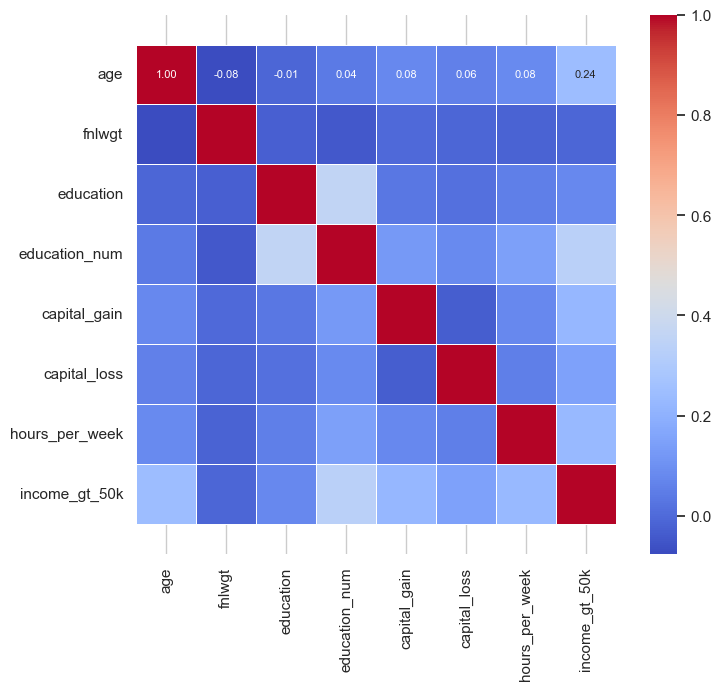

                     age    fnlwgt  education  education_num  capital_gain  \
age             1.000000 -0.075121  -0.008399       0.041005      0.079492   
fnlwgt         -0.075121  1.000000  -0.027971      -0.043339      0.000459   
education      -0.008399 -0.027971   1.000000       0.357703      0.030149   
education_num   0.041005 -0.043339   0.357703       1.000000      0.122713   
capital_gain    0.079492  0.000459   0.030149       0.122713      1.000000   
capital_loss    0.057136 -0.009475   0.016468       0.080487     -0.031598   
hours_per_week  0.082650 -0.019604   0.054775       0.147309      0.078142   
income_gt_50k   0.242776 -0.009538   0.078966       0.335139      0.222987   

                capital_loss  hours_per_week  income_gt_50k  
age                 0.057136        0.082650       0.242776  
fnlwgt             -0.009475       -0.019604      -0.009538  
education           0.016468        0.054775       0.078966  
education_num       0.080487        0.147309     

In [14]:
# Select only numerical columns for correlation calculation
numerical_data = data.select_dtypes(include=[np.number])  # Ensures only numeric columns are included

# Compute the correlation matrix
corr = numerical_data.corr()

f, ax = plt.subplots(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 8})


# Improve the visibility of the heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Show the plot
plt.show()

print(corr)

- **age**: It has a strong positive correlation (0.24) with 'income_gt_50k', suggesting that as age increases, so does the likelihood of having an income greater than $50,000. This could indicate that experience and seniority, which often come with age, may be linked to higher earnings.

- **fnlwgt**: This variable shows very weak correlations with all other variables. The correlation with 'income_gt_50k' is also very weak and negative (-0.0095), indicating that this variable might not be a good predictor for income in this dataset.

- **education** and **education_num**: There's a strong positive correlation (0.3577) between 'education' and 'education_num', which is expected since they likely represent similar attributes, one in a categorical form and the other numerical. 'Education_num' also has a significant positive correlation (0.3351) with 'income_gt_50k', suggesting that higher educational attainment might be associated with higher income.

- **capital_gain** and **capital_loss**: Both 'capital_gain' and 'capital_loss' show positive correlations with 'income_gt_50k', with 'capital_gain' having a more substantial correlation (0.223). This suggests that individuals with higher capital gains and losses might have higher incomes, possibly reflecting investment income or the financial sophistication that correlates with higher earnings.

- **hours_per_week**: It has a moderately positive correlation (0.229) with 'income_gt_50k'. This could indicate that working more hours is associated with higher income, which might reflect overtime pay or the fact that higher-paid jobs often demand more hours.

In summary, 'age', 'education_num', 'capital_gain', and 'hours_per_week' are the variables most positively correlated with the target 'income_gt_50k'. These factors seem to be the strongest predictors of having an income greater than $50,000 according to this correlation matrix. However, it is important to note that correlation does not imply causation. Further analysis, such as regression modeling, would be necessary to understand the causal relationships and to build a predictive model for income.

For both logistic regression and SVMs, it is generally recommended to scale features, especially when they are measured in different units (like height in cm and weight in kg) or they vary in terms of their ranges. Common methods for scaling include min-max scaling, standardization (subtracting the mean and dividing by the standard deviation), and scaling to unit length.

In this dataset we have a few features measured in different units, like "age", "fnlwgt", "capital_gain", and "capital_loss".

In [15]:
X = data.drop(['income', 'income_gt_50k'], axis=1)
y = data['income_gt_50k']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [17]:
# SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(probability=True)

In [18]:
# Predictions
log_pred = log_model.predict(X_test_scaled)
svm_pred = svm_model.predict(X_test_scaled)

In [19]:
print("nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, log_pred))
print("\nSVM Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))

# Specificity calculation: specificity = TN / (TN + FP)
tn, fp, fn, tp = confusion_matrix(y_test, log_pred).ravel()
log_specificity = tn / (tn + fp)

tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
svm_specificity = tn / (tn + fp)


nLogistic Regression Confusion Matrix:
 [[6919  549]
 [ 920 1344]]

SVM Confusion Matrix:
 [[6970  498]
 [ 988 1276]]


In [20]:
# Dictionary to store the metrics
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'ROC AUC'],
    'Logistic Regression': [
        accuracy_score(y_test, log_pred), 
        precision_score(y_test, log_pred), 
        recall_score(y_test, log_pred), 
        f1_score(y_test, log_pred), 
        log_specificity, 
        roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:,1])
    ],
    'SVM': [
        accuracy_score(y_test, svm_pred), 
        precision_score(y_test, svm_pred), 
        recall_score(y_test, svm_pred), 
        f1_score(y_test, svm_pred), 
        svm_specificity, 
        roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:,1])
    ]
}

# Creating the DataFrame
metrics_df = pd.DataFrame(data)

# Displaying the DataFrame
print(metrics_df)


        Metric  Logistic Regression       SVM
0     Accuracy             0.849055  0.847308
1    Precision             0.709984  0.719278
2       Recall             0.593640  0.563604
3     F1 Score             0.646620  0.631996
4  Specificity             0.926486  0.933315
5      ROC AUC             0.901928  0.893625


In [21]:
# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Evaluate the best model found by grid search
best_svm_model = grid_search.best_estimator_
best_svm_pred = best_svm_model.predict(X_test_scaled)

# Accessing the hyperparameters of the best model
best_svm_hyperparameters = best_svm_model.get_params()
print("\nBest SVM Model Hyperparameters:")
print(best_svm_hyperparameters)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  29.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  28.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  28.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  30.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  29.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  14.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  14.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  14.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  14.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  15.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  24.8s
[CV] END .......................C=0.1, gamma=0.1

In [22]:
# Calculate metrics for the best SVM
tn, fp, fn, tp = confusion_matrix(y_test, best_svm_pred).ravel()
best_svm_specificity = tn / (tn+fp)

best_svm_metrics = {
    'Accuracy': accuracy_score(y_test, best_svm_pred),
    'Precision': precision_score(y_test, best_svm_pred),
    'Recall': recall_score(y_test, best_svm_pred),
    'F1 Score': f1_score(y_test, best_svm_pred),
    'Specificity': best_svm_specificity,
    'ROC AUC': roc_auc_score(y_test, best_svm_model.decision_function(X_test_scaled))
}

# Add these metrics as a new column to the DataFrame
metrics_df['Best SVM'] = best_svm_metrics.values()

# Display the updated DataFrame
print(metrics_df)


        Metric  Logistic Regression       SVM  Best SVM
0     Accuracy             0.849055  0.847308  0.855528
1    Precision             0.709984  0.719278  0.728191
2       Recall             0.593640  0.563604  0.604682
3     F1 Score             0.646620  0.631996  0.660714
4  Specificity             0.926486  0.933315  0.931575
5      ROC AUC             0.901928  0.893625  0.899208


The performance metrics for the three models indicate that each has its strengths:

- **Accuracy**: All three models have similar accuracy, with the Best SVM model slightly ahead. Accuracy is a good measure when the class distribution is balanced but doesn't account for the costs of different types of errors.

- **Precision**: Precision is highest for the Best SVM model, followed closely by SVM and Logistic Regression. If the cost of false positives is high in your application (i.e., you want to minimize the number of negative instances that are incorrectly classified as positive), we might lean towards the Best SVM model.

- **Recall**: Recall is highest for the Logistic Regression model, followed by the Best SVM and then SVM. If the cost of false negatives is high (i.e., failing to identify positive instances is costly), the Logistic Regression model might be preferable.

- **F1 Score**: The F1 score, which balances precision and recall, is highest for the Best SVM, followed by Logistic Regression and then SVM. The Best SVM would be preferred if you seek a balance between precision and recall.

- **Specificity**: Specificity is very similar across all models, with the SVM slightly ahead. This metric is important if you want to ensure that positive instances are not misclassified as negative.

- **ROC AUC**: The ROC AUC is highest for Logistic Regression, indicating it might be the best at distinguishing between the classes overall.

Choosing between these models depends on the specific context of the problem and the costs associated with false positives and false negatives. Here's how to decide:

- **If interpretability is a key requirement**, we might favor Logistic Regression. Logistic Regression models are easier to interpret, and the coefficients of the model can provide insights into the importance of each feature. This can be particularly valuable in domains like medicine or finance, where understanding the model's decision-making process is as important as the decision itself.

- **If performance is the sole focus**, and the differences in metrics are meaningful for the problem at hand, we might choose the Best SVM since it has the highest F1 score and accuracy, suggesting a good balance between recall and precision, and overall correct classification rate.

- **If you must minimize false negatives**, the higher recall of the Logistic Regression might make it the best choice, as it is more likely to identify positive instances correctly.

- **If computational cost during prediction time is a concern**, Logistic Regression is typically faster for making predictions than SVM, which can be an advantage in real-time systems.

In summary, if the simplicity and interpretability of Logistic Regression provide sufficient performance for our needs, it could be the preferred model. However, if the slightly better balance of performance metrics of the Best SVM is crucial for the application, and the increased complexity is acceptable, then the Best SVM might be the way to go. Always consider the domain-specific implications of model choice, and if possible, consult with domain experts to understand the impact of different types of errors.